# Preprocessing

In [1]:
from __future__ import print_function
import numpy as np
import gzip
import os
import sys
import pickle as pkl
from utils import *

In [2]:
folder = 'data/'
files = [folder+'ctrain.txt', folder+'ctest.txt']

In [3]:
folder = 'data/'
outputFilePath = folder + 'causal-relations.pkl.gz'
#Download English word embeddings from here https://www.cs.york.ac.uk/nlp/extvec/
embeddingsPath = folder + 'wiki_extvec.gz'
files = [folder+'ctrain.txt', folder+'ctest.txt']

In [4]:
#Mapping of the labels to integers
labelsMapping = {'Other':0, 'Cause-Effect(e1,e2)':1, 'Cause-Effect(e2,e1)':2}
words = {}
maxSentenceLen = [0,0]
minDistance = -30
maxDistance = 30

for fileIdx in range(len(files)):
    file = files[fileIdx]
    for line in open(file):
        splits = line.strip().split('\t')
        label = splits[0]
        sentence = splits[3]        
        tokens = sentence.split(" ")
        maxSentenceLen[fileIdx] = max(maxSentenceLen[fileIdx], len(tokens))
        for token in tokens:
            words[token.lower()] = True

In [5]:
print("Max Sentence Lengths: ", maxSentenceLen)

Max Sentence Lengths:  [97, 67]


Extended Dependency Based Skip-gram
The Extended Dependency Based Skip-gram is a method for training word embeddings using structural information from dependency graphs. In addition to standard word embeddings, it produces embeddings of dependency context features (e.g. det_a, compound_programming, compound_inv_language) which were found to be useful features in several sentence classification tasks.

In [6]:
# :: Read in word embeddings ::
word2Idx = {}
wordEmbeddings = []

# :: Downloads the embeddings from the York webserver ::
if not os.path.isfile(embeddingsPath):
    basename = os.path.basename(embeddingsPath)
    if basename == 'wiki_extvec.gz':
           print("Start downloading word embeddings for English using wget ...")
           #os.system("wget https://www.cs.york.ac.uk/nlp/extvec/"+basename+" -P embeddings/")
           os.system("wget https://public.ukp.informatik.tu-darmstadt.de/reimers/2017_english_embeddings/"+basename+" -P embeddings/")
    else:
        print(embeddingsPath, "does not exist. Please provide pre-trained embeddings")
        exit()
        
# :: Load the pre-trained embeddings file ::
fEmbeddings = gzip.open(embeddingsPath, "r") if embeddingsPath.endswith('.gz') else open(embeddingsPath, encoding="utf8")

In [7]:
print("Load pre-trained embeddings file")
for line in fEmbeddings:
    
    split = line.decode('utf-8').strip().split(" ")
    word = split[0]
    
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING_TOKEN"] = len(word2Idx)
        vector = np.zeros(len(split)-1) #Zero vector vor 'PADDING' word
        wordEmbeddings.append(vector)
        
        word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, len(split)-1)
        wordEmbeddings.append(vector)

    if word.lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        wordEmbeddings.append(vector)
        word2Idx[word] = len(word2Idx)
       
        
wordEmbeddings = np.array(wordEmbeddings)

Load pre-trained embeddings file


In [8]:
print("Embeddings shape: ", wordEmbeddings.shape)
print("Len words: ", len(words))

Embeddings shape:  (21243, 300)
Len words:  23503


In [9]:
# :: Create token matrix ::
vectorizer = Vectorizer(word2Idx, labelsMapping, minDistance, maxDistance, max(maxSentenceLen))
train_set = vectorizer.vectorizeInput(files[0])
test_set = vectorizer.vectorizeInput(files[1])

data = {'wordEmbeddings': wordEmbeddings, 'word2Idx': word2Idx, 
        'train_set': train_set, 'test_set': test_set, 'labels_mapping': labelsMapping, 'max_sentence_length': max(maxSentenceLen), 'min_distance': minDistance, 'max_distance': maxDistance}

f = gzip.open(outputFilePath, 'wb')
pkl.dump(data, f)
f.close()

print("Data stored in pkl folder") 

Data stored in pkl folder


# Training 

In [10]:
import tensorflow as tf

In [11]:
import tensorflow.python.keras
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation, Flatten, concatenate
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Convolution1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.python.keras.regularizers import Regularizer
from tensorflow.python.keras.preprocessing import sequence

In [12]:
batch_size = 64
nb_filter = 100
filter_length = 3
hidden_dims = 100
nb_epoch = 30
position_dims = 50

In [13]:
print("Load dataset")
f = gzip.open('data/causal-relations.pkl.gz', 'rb')
data = pkl.load(f)
f.close()

Load dataset


In [14]:
embeddings = data['wordEmbeddings']
yTrain, sentenceTrain, positionTrain1, positionTrain2 = data['train_set']
yTest, sentenceTest, positionTest1, positionTest2  = data['test_set']

max_position = max(np.max(positionTrain1), np.max(positionTrain2))+1

n_out = max(yTrain)+1
#train_y_cat = np_utils.to_categorical(yTrain, n_out)
max_sentence_len = sentenceTrain.shape[1]

In [15]:
print("sentenceTrain: ", sentenceTrain.shape)
print("positionTrain1: ", positionTrain1.shape)
print("yTrain: ", yTrain.shape)
print("sentenceTest: ", sentenceTest.shape)
print("positionTest1: ", positionTest1.shape)
print("yTest: ", yTest.shape)
print("Embeddings: ",embeddings.shape)

sentenceTrain:  (8000, 97)
positionTrain1:  (8000, 97)
yTrain:  (8000,)
sentenceTest:  (2717, 97)
positionTest1:  (2717, 97)
yTest:  (2717,)
Embeddings:  (21243, 300)


# Build the model

## This is a CNN for relation classification within a sentence.

In [16]:
words_input = Input(shape=(max_sentence_len,), dtype='int32', name='words_input')
words = Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], trainable=False)(words_input)

distance1_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance1_input')
distance1 = Embedding(max_position, position_dims)(distance1_input)

distance2_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance2_input')
distance2 = Embedding(max_position, position_dims)(distance2_input)

output = concatenate([words, distance1, distance2])

output = Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same',
                        activation='tanh',
                        strides=1)(output)

# standard max over time pooling
output = GlobalMaxPooling1D()(output)

output = Dropout(0.25)(output)
output = Dense(n_out, activation='softmax')(output)
model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.summary()

print("Start training")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance1_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance2_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 97, 300)      6372900     words_input[0][0]                
______________________________________________________________________________________________

## Compute f1 score for each epoch in Keras

### Mathematical equation

In [18]:
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0

def getPrecision(pred_test, yTest, targetLabel):
    #Precision for non-vague
    targetLabelCount = 0
    correctTargetLabelCount = 0
    
    for idx in range(len(pred_test)): 
        if pred_test[idx] == targetLabel:
            targetLabelCount += 1
            
            if pred_test[idx] == yTest[idx]:
                correctTargetLabelCount += 1
    
    if correctTargetLabelCount == 0:
        return 0
    
    return float(correctTargetLabelCount) / targetLabelCount

In [19]:
def predict_classes(prediction):
    
    return prediction.argmax(axis=-1)

for epoch in range(nb_epoch):       
    model.fit([sentenceTrain, positionTrain1, positionTrain2], yTrain, batch_size=batch_size, verbose=True,epochs=1)   
    pred_test_ini = model.predict([sentenceTest, positionTest1, positionTest2], verbose=False)
    pred_test = predict_classes(pred_test_ini)
    
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)
   
    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print("Accuracy: %.4f (max: %.4f)" % (acc, max_acc))

    f1Sum = 0
    f1Count = 0
    for targetLabel in range(1, max(yTest)):        
        prec = getPrecision(pred_test, yTest, targetLabel)
        recall = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+recall) == 0 else 2*prec*recall/(prec+recall)
        f1Sum += f1
        f1Count +=1    
        
        
    macroF1 = f1Sum / float(f1Count)    
    max_f1 = max(max_f1, macroF1)
    print("Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1))

125/125 [==============================] - 6s 47ms/step - loss: 0.3027 - accuracy: 0.9068
Accuracy: 0.9580 (max: 0.9580)
Non-other Macro-Averaged F1: 0.7431 (max: 0.7431)

125/125 [==============================] - 5s 42ms/step - loss: 0.1221 - accuracy: 0.9625
Accuracy: 0.9735 (max: 0.9735)
Non-other Macro-Averaged F1: 0.8724 (max: 0.8724)

125/125 [==============================] - 5s 41ms/step - loss: 0.0764 - accuracy: 0.9737
Accuracy: 0.9772 (max: 0.9772)
Non-other Macro-Averaged F1: 0.9084 (max: 0.9084)

125/125 [==============================] - 6s 46ms/step - loss: 0.0492 - accuracy: 0.9868
Accuracy: 0.9790 (max: 0.9790)
Non-other Macro-Averaged F1: 0.9134 (max: 0.9134)

125/125 [==============================] - 6s 48ms/step - loss: 0.0306 - accuracy: 0.9931
Accuracy: 0.9805 (max: 0.9805)
Non-other Macro-Averaged F1: 0.9176 (max: 0.9176)

125/125 [==============================] - 6s 47ms/step - loss: 0.0198 - accuracy: 0.9962
Accuracy: 0.9787 (max: 0.9805)
Non-other Macro-Ave

In [20]:
model.save('model/causal_rel_model.h5')  # creates a HDF5 file 'my_model.h5'

### Add validation_split and EarlyStopping on val_accuracy

#### Rebuild the model

In [22]:
words_input = Input(shape=(max_sentence_len,), dtype='int32', name='words_input')
words = Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], trainable=False)(words_input)

distance1_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance1_input')
distance1 = Embedding(max_position, position_dims)(distance1_input)

distance2_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance2_input')
distance2 = Embedding(max_position, position_dims)(distance2_input)

output = concatenate([words, distance1, distance2])

output = Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same',
                        activation='tanh',
                        strides=1)(output)

# standard max over time pooling
output = GlobalMaxPooling1D()(output)

output = Dropout(0.25)(output)
output = Dense(n_out, activation='softmax')(output)
model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.summary()

print("Start training")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance1_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance2_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 97, 300)      6372900     words_input[0][0]                
____________________________________________________________________________________________

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
history=model.fit([sentenceTrain, positionTrain1, positionTrain2], yTrain, batch_size=batch_size, verbose=True,epochs=125,validation_steps=1,validation_split=0.2, callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=2),
        ModelCheckpoint('models/cnn_model.h5')
    ],)

Epoch 1/125
100/100 [==============================] - 5s 49ms/step - loss: 0.3444 - accuracy: 0.8966 - val_loss: 0.1878 - val_accuracy: 0.9219
Epoch 2/125
100/100 [==============================] - 5s 51ms/step - loss: 0.1232 - accuracy: 0.9675 - val_loss: 0.1134 - val_accuracy: 0.9531
Epoch 3/125
100/100 [==============================] - 5s 51ms/step - loss: 0.0715 - accuracy: 0.9794 - val_loss: 0.0859 - val_accuracy: 0.9844
Epoch 4/125
100/100 [==============================] - 6s 58ms/step - loss: 0.0497 - accuracy: 0.9855 - val_loss: 0.0874 - val_accuracy: 0.9844
Epoch 5/125
100/100 [==============================] - 5s 50ms/step - loss: 0.0309 - accuracy: 0.9917 - val_loss: 0.0889 - val_accuracy: 0.9844


### Keras macro custom_F1

In [28]:
### Define F1 measures: F1 = 2 * (precision * recall) / (precision + recall)
from tensorflow.keras import backend as K

def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [29]:
#Rebuild the model
words_input = Input(shape=(max_sentence_len,), dtype='int32', name='words_input')
words = Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], trainable=False)(words_input)

distance1_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance1_input')
distance1 = Embedding(max_position, position_dims)(distance1_input)

distance2_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance2_input')
distance2 = Embedding(max_position, position_dims)(distance2_input)

output = concatenate([words, distance1, distance2])

output = Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same',
                        activation='tanh',
                        strides=1)(output)

# standard max over time pooling
output = GlobalMaxPooling1D()(output)

output = Dropout(0.25)(output)
output = Dense(n_out, activation='softmax')(output)
model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy',custom_f1])
model.summary()

print("Start training")

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance1_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance2_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 97, 300)      6372900     words_input[0][0]                
____________________________________________________________________________________________

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
history=model.fit([sentenceTrain, positionTrain1, positionTrain2], yTrain, batch_size=batch_size, verbose=True,epochs=125,validation_steps=1,validation_split=0.2, callbacks=[
        EarlyStopping(monitor='val_custom_f1', patience=2),
        ModelCheckpoint('models/cnn_model_keras_f1.h5')
    ],)

Epoch 1/125
100/100 [==============================] - 6s 56ms/step - loss: 0.2991 - accuracy: 0.9089 - custom_f1: 0.2435 - val_loss: 0.1407 - val_accuracy: 0.9531 - val_custom_f1: 0.2778
Epoch 2/125
100/100 [==============================] - 5s 55ms/step - loss: 0.1084 - accuracy: 0.9697 - custom_f1: 0.2253 - val_loss: 0.0886 - val_accuracy: 0.9844 - val_custom_f1: 0.2740
Epoch 3/125
100/100 [==============================] - 6s 56ms/step - loss: 0.0657 - accuracy: 0.9797 - custom_f1: 0.2242 - val_loss: 0.0807 - val_accuracy: 0.9844 - val_custom_f1: 0.2466
Epoch 4/125
100/100 [==============================] - 6s 57ms/step - loss: 0.0442 - accuracy: 0.9878 - custom_f1: 0.2233 - val_loss: 0.0852 - val_accuracy: 0.9844 - val_custom_f1: 0.2740
Epoch 5/125
100/100 [==============================] - 6s 56ms/step - loss: 0.0267 - accuracy: 0.9939 - custom_f1: 0.2182 - val_loss: 0.0831 - val_accuracy: 0.9844 - val_custom_f1: 0.2466


# Evaluate the model 

### Accuracy graph

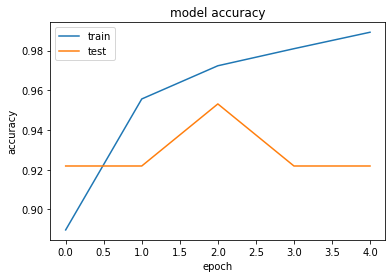

In [121]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Loss graph

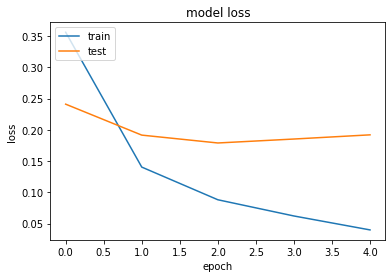

In [122]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the plot of loss, we can see that the model has comparable performance on both train and validation datasets (labeled test).

### Sklearn micro and macro avg
Les moyennes micro et macro (quelle que soit la métrique) calculent des choses légèrement différentes, et donc leur interprétation diffère. Une macro-moyenne calcule la métrique indépendamment pour chaque classe, puis prend la moyenne (donc toutes les classes sont traitées de manière égale), tandis qu'une micro-moyenne agrégera les contributions de toutes les classes pour calculer la métrique moyenne. 

In [ ]:
model = load_model('model/causal_rel_model.h5')

In [32]:
from sklearn.metrics import f1_score

In [33]:
f1_score(yTest, pred_test, average='macro')

0.9423787543676397

In [34]:
f1_score(yTest, pred_test, average='micro')

0.9815973500184026

In [35]:
f1_score(yTest, pred_test, average='weighted')

0.981380741347552

In [36]:
f1_score(yTest, pred_test, average=None)

array([0.99040867, 0.93333333, 0.90339426])

In [44]:
pred_train_ini=model.predict([sentenceTrain, positionTrain1, positionTrain2], verbose=False)
pred_train_ini.shape
pred_train=predict_classes(pred_train_ini)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
print(classification_report(yTest, pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2389
           1       0.98      0.89      0.93       134
           2       0.92      0.89      0.90       194

    accuracy                           0.98      2717
   macro avg       0.96      0.92      0.94      2717
weighted avg       0.98      0.98      0.98      2717



In [30]:
print(confusion_matrix(yTest, pred_test))

[[2375    2   12]
 [  11  119    4]
 [  21    0  173]]


In [40]:
pred_test.shape

(2717, 3)

In [41]:
yTrain.shape

(8000,)

In [45]:
print(classification_report(yTrain, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6997
           1       1.00      1.00      1.00       344
           2       1.00      1.00      1.00       659

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



# ReduceLROnPlateau

In [90]:
from keras.callbacks import ReduceLROnPlateau

In [91]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [92]:
words_input = Input(shape=(max_sentence_len,), dtype='int32', name='words_input')
words = Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], trainable=False)(words_input)

distance1_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance1_input')
distance1 = Embedding(max_position, position_dims)(distance1_input)

distance2_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance2_input')
distance2 = Embedding(max_position, position_dims)(distance2_input)

output = concatenate([words, distance1, distance2])

output = Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same',
                        activation='tanh',
                        strides=1)(output)

# standard max over time pooling
output = GlobalMaxPooling1D()(output)

output = Dropout(0.25)(output)
output = Dense(n_out, activation='softmax')(output)
model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy',custom_f1])
model.summary()

print("Start training")

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance1_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance2_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 97, 300)      6372900     words_input[0][0]                
____________________________________________________________________________________________

In [93]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
history=model.fit([sentenceTrain, positionTrain1, positionTrain2], yTrain, batch_size=batch_size, verbose=True,epochs=125,validation_steps=1,validation_split=0.2, callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=2),
        ModelCheckpoint('models/cnn_model_keras_f1.h5'),reduce_lr
    ],)

Epoch 1/125
100/100 [==============================] - 4s 41ms/step - loss: 0.2865 - accuracy: 0.9147 - custom_f1: 0.2380 - val_loss: 0.1601 - val_accuracy: 0.9219 - val_custom_f1: 0.2500
Epoch 2/125
100/100 [==============================] - 4s 41ms/step - loss: 0.1065 - accuracy: 0.9722 - custom_f1: 0.2261 - val_loss: 0.1044 - val_accuracy: 0.9844 - val_custom_f1: 0.2740
Epoch 3/125
100/100 [==============================] - 4s 41ms/step - loss: 0.0635 - accuracy: 0.9803 - custom_f1: 0.2262 - val_loss: 0.0867 - val_accuracy: 0.9844 - val_custom_f1: 0.2466
Epoch 4/125
100/100 [==============================] - 4s 41ms/step - loss: 0.0387 - accuracy: 0.9886 - custom_f1: 0.2215 - val_loss: 0.0820 - val_accuracy: 0.9844 - val_custom_f1: 0.2466


#  Compute f1 score for each epoch in Keras

### Split train dataset into train and val

In [22]:
#Split train dataset into train and val
from sklearn.model_selection import train_test_split

In [23]:
sentenceTrain0,sentenceVal0, positionTrain01, positionVal01, positionTrain02, positionVal02,yTrain0,yVal0=train_test_split(sentenceTrain, positionTrain1, positionTrain2,yTrain, test_size = 0.2)

In [24]:
print("sentenceTrain: ", sentenceTrain.shape)
print("positionTrain1: ", positionTrain1.shape)
print("positionTr2: ", positionTrain2.shape)

sentenceTrain:  (8000, 97)
positionTrain1:  (8000, 97)
positionTr2:  (8000, 97)


In [25]:
print("sentenceTrain: ", sentenceTrain0.shape)
print("positionTrain1: ", positionTrain01.shape)
print("positionTrain2: ", positionTrain02.shape)
print("yTrain: ", yTrain0.shape)

sentenceTrain:  (6400, 97)
positionTrain1:  (6400, 97)
positionTrain2:  (6400, 97)
yTrain:  (6400,)


In [26]:
print("sentenceVal: ", sentenceVal0.shape)
print("positionVal1: ", positionVal01.shape)
print("positionVal2: ", positionVal02.shape)
print("yVal: ", yVal0.shape)

sentenceVal:  (1600, 97)
positionVal1:  (1600, 97)
positionVal2:  (1600, 97)
yVal:  (1600,)


In [27]:
words_input = Input(shape=(max_sentence_len,), dtype='int32', name='words_input')
words = Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], trainable=False)(words_input)

distance1_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance1_input')
distance1 = Embedding(max_position, position_dims)(distance1_input)

distance2_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance2_input')
distance2 = Embedding(max_position, position_dims)(distance2_input)

output = concatenate([words, distance1, distance2])

output = Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same',
                        activation='tanh',
                        strides=1)(output)

# standard max over time pooling
output = GlobalMaxPooling1D()(output)

output = Dropout(0.25)(output)
output = Dense(n_out, activation='softmax')(output)
#model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
inputs=[words_input, distance1_input, distance2_input]
outputs=[output]
model=tf.keras.Model(inputs, outputs)
model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy'],run_eagerly=True)
model.summary()

print("Start training")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance1_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance2_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 97, 300)      6372900     words_input[0][0]                
______________________________________________________________________________________________

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self,sentenceVal0,positionVal01,positionVal02,yVal0,patience):

        self.patience=patience
        self.sentenceVal0 =sentenceVal0
        self.positionVal01 = positionVal01
        self.positionVal02 = positionVal02
        self.yVal0 = yVal0 
        self.max_f1=0
        self.wait=None 

        
    def on_train_begin(self, logs={}):
        self._data = []
        self.best=-1
        self.ema=-1
        self.best_diff=-1
        self.mean=[]
        self.std=[]
        self.wait=0
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
    def set_model(self, model):
        self.model = model
    def on_epoch_end(self, batch, logs={}):
        from tensorflow.python.keras import backend as K
        from tensorflow.keras.layers import Lambda
        f = tf.keras.backend.function([self.model.inputs],[self.model.outputs])
        

    #####################################Prediction##############################
     
        pred=np.array(f([[self.sentenceVal0,self.positionVal01,self.positionVal02], True])).reshape(-1,1)
        
        Y_pred=pred 
        
        Y_pred=np.asarray(Y_pred)

        # Calculate mean and standard deviation.
        Y_pred_m = np.mean(Y_pred, axis=0)
        val_predict = (np.asarray(self.model.predict([sentenceVal0,positionVal01,positionVal02], verbose=False).argmax(axis=-1))).round()
        val_targ = np.asarray(yVal0)
        _val_f1 = f1_score(val_targ, val_predict,average='macro')
        _val_recall = recall_score(val_targ, val_predict,average='macro')
        _val_precision = precision_score(val_targ, val_predict,average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        if(self.val_f1s[-1] >self.max_f1):
            self.wait=0
            self.max_f1=self.val_f1s[-1]
        else :
            self.wait+=1
            if self.wait >= self.patience:
                self.model.stop_training = True        


In [29]:
metrics = Metrics(words_input,distance1_input,distance2_input,output,patience=2) 

In [96]:
tf.compat.v1.enable_eager_execution()

In [97]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
history=model.fit([sentenceTrain0, positionTrain01, positionTrain02], yTrain0, batch_size=batch_size, verbose=True,epochs=20,validation_steps=1,validation_data=([sentenceVal0,positionVal01,positionVal02], yVal0), callbacks=[metrics
        ,ModelCheckpoint('models/cnn_model_val_f1.h5')])

Epoch 1/20
100/100 [==============================] - 6s 59ms/step - loss: 0.3562 - accuracy: 0.8897 - val_loss: 0.2411 - val_accuracy: 0.9219
— val_f1: 0.825806 — val_precision: 0.942150 — val_recall 0.751732
Epoch 2/20
100/100 [==============================] - 6s 65ms/step - loss: 0.1403 - accuracy: 0.9556 - val_loss: 0.1915 - val_accuracy: 0.9219
— val_f1: 0.861526 — val_precision: 0.936235 — val_recall 0.806810
Epoch 3/20
100/100 [==============================] - 7s 66ms/step - loss: 0.0881 - accuracy: 0.9723 - val_loss: 0.1789 - val_accuracy: 0.9531
— val_f1: 0.879963 — val_precision: 0.895751 — val_recall 0.867407
Epoch 4/20
100/100 [==============================] - 7s 66ms/step - loss: 0.0621 - accuracy: 0.9809 - val_loss: 0.1853 - val_accuracy: 0.9219
— val_f1: 0.875011 — val_precision: 0.935577 — val_recall 0.827486
Epoch 5/20
100/100 [==============================] - 7s 66ms/step - loss: 0.0398 - accuracy: 0.9892 - val_loss: 0.1920 - val_accuracy: 0.9219
— val_f1: 0.87586

In [ ]:
loss: 0.0871 - accuracy: 0.9881 - val_loss: 0.1239 - val_accuracy: 0.9219
— val_f1: 0.887510 — val_precision: 0.884502 — val_recall 0.891561


In [98]:
model.evaluate([sentenceTest, positionTest1, positionTest2], yTest)

85/85 [==============================] - 1s 13ms/step - loss: 0.0792 - accuracy: 0.9753


[0.07920163869857788, 0.9753404259681702]

# Set class weights for imbalenced classes:

In SemEval2010_task8 dataset there are:

6996 'Other' relation 

659  'Cause-Effect(e2,e1)' effect relation

344 'Cause-Effect(e1,e2)' causality relation.

=> The classes are imbalenced

In order to force the algorithm to treat every instance of class 1 as 20 instances of class 0 and  every instance of class 2 as 10 instances of class 0:
    class_weight = {0: 1.,
                1: 20.,
                2: 10.}

In [21]:
words_input = Input(shape=(max_sentence_len,), dtype='int32', name='words_input')
words = Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], trainable=False)(words_input)

distance1_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance1_input')
distance1 = Embedding(max_position, position_dims)(distance1_input)

distance2_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance2_input')
distance2 = Embedding(max_position, position_dims)(distance2_input)

output = concatenate([words, distance1, distance2])

output = Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same',
                        activation='tanh',
                        strides=1)(output)

# standard max over time pooling
output = GlobalMaxPooling1D()(output)

output = Dropout(0.25)(output)
output = Dense(n_out, activation='softmax')(output)
#model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
inputs=[words_input, distance1_input, distance2_input]
outputs=[output]
model=tf.keras.Model(inputs, outputs)
model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy'],run_eagerly=True)
model.summary()

print("Start training")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance1_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance2_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 97, 300)      6372900     words_input[0][0]                
______________________________________________________________________________________________

In [30]:
#saving weights
model.save_weights('models/model_weights', save_format='tf')

In [31]:
#layer weights from the model 
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict)

{'words_input': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa8c76b1af0>, 'distance1_input': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa8c76b1c70>, 'distance2_input': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa8c76a3580>, 'embedding_3': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fa8c76b1ac0>, 'embedding_4': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fa8c76b1a90>, 'embedding_5': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x7fa8c76a3d90>, 'concatenate_1': <tensorflow.python.keras.layers.merge.Concatenate object at 0x7fa8c76b5640>, 'conv1d_1': <tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7fa8c76b5f10>, 'global_max_pooling1d_1': <tensorflow.python.keras.layers.pooling.GlobalMaxPooling1D object at 0x7fa8c763fc40>, 'dropout_1': <tensorflow.python.keras.layers.core.Dropout object at 0x7fa8c763fc70>, 'dense_1': <tensorflow.python.ke

In [44]:
# creating the same model architecture and compile
loaded_model = model

In [33]:
# This initializes the variables used by the optimizers,
# as well as any stateful metric variables
loaded_model.train_on_batch([sentenceTrain0, positionTrain01, positionTrain02], yTrain0)

[1.0909836292266846, 0.3881250023841858]

In [34]:
# loading the weights from base_model
for layer in loaded_model.layers:    
    layer_name = layer.name
    print(layer.name)
    layer.set_weights(layer_dict[layer_name].get_weights())

words_input
distance1_input
distance2_input
embedding_3
embedding_4
embedding_5
concatenate_1
conv1d_1
global_max_pooling1d_1
dropout_1
dense_1


In [35]:
# accessing weights of a layer by its name
layer_dict[layer_name].get_weights()

[array([[ 0.06584784,  0.04598597, -0.2018772 ],
        [-0.11449538,  0.01961733, -0.1315861 ],
        [-0.13925493, -0.01714204,  0.1198431 ],
        [-0.14184678, -0.14569642, -0.10084689],
        [ 0.16244678, -0.17144649,  0.23330697],
        [ 0.11243066, -0.07467834, -0.21872064],
        [ 0.2350895 , -0.17133927, -0.23790878],
        [ 0.12229478, -0.0974419 ,  0.16282296],
        [ 0.2002332 , -0.10006623, -0.09923714],
        [-0.01594942, -0.01384284,  0.17669639],
        [-0.1299595 , -0.14023335,  0.06011204],
        [-0.17800587,  0.06013442, -0.14965059],
        [-0.20020044, -0.05795054, -0.17513332],
        [-0.1377841 ,  0.07657465, -0.04860032],
        [ 0.01313025,  0.14049108, -0.14801727],
        [-0.09398449, -0.12705463, -0.12970206],
        [-0.06437083, -0.06048926,  0.22343053],
        [ 0.19503227,  0.12673543,  0.12105651],
        [-0.06646761,  0.11810388,  0.1433471 ],
        [-0.0564209 , -0.17521441,  0.06036901],
        [ 0.10247612

In [36]:
# check the evaluation before and after are same
loaded_model.evaluate([sentenceTest, positionTest1, positionTest2], yTest)

85/85 [==============================] - 2s 18ms/step - loss: 0.6317 - accuracy: 0.8793


[0.6316894292831421, 0.8792786002159119]

In [37]:
print(loaded_model.weights)

[<tf.Variable 'embedding_3/embeddings:0' shape=(21243, 300) dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06115359, -0.12306087, -0.19337489, ...,  0.11880438,
        -0.17970166, -0.21234585],
       [ 0.152895  , -0.037006  ,  0.12676   , ...,  0.09854   ,
         0.530776  , -0.232594  ],
       ...,
       [ 0.008987  ,  0.003346  ,  0.048075  , ...,  0.601451  ,
         0.218893  ,  0.045559  ],
       [ 0.1964    , -0.546759  , -0.395152  , ..., -0.148597  ,
         0.909782  , -0.701796  ],
       [ 0.537103  ,  0.356573  ,  0.528078  , ..., -0.283193  ,
         0.23536   , -0.152445  ]], dtype=float32)>, <tf.Variable 'embedding_4/embeddings:0' shape=(64, 50) dtype=float32, numpy=
array([[-0.01413449, -0.03184837, -0.02254126, ..., -0.01360248,
        -0.00582602, -0.02421376],
       [ 0.04195855,  0.03802381,  0.04594328, ..., -0.03400361,
        -0.01472078, -0.04502352],
       [ 0.

In [38]:
print(model.weights)

[<tf.Variable 'embedding_3/embeddings:0' shape=(21243, 300) dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06115359, -0.12306087, -0.19337489, ...,  0.11880438,
        -0.17970166, -0.21234585],
       [ 0.152895  , -0.037006  ,  0.12676   , ...,  0.09854   ,
         0.530776  , -0.232594  ],
       ...,
       [ 0.008987  ,  0.003346  ,  0.048075  , ...,  0.601451  ,
         0.218893  ,  0.045559  ],
       [ 0.1964    , -0.546759  , -0.395152  , ..., -0.148597  ,
         0.909782  , -0.701796  ],
       [ 0.537103  ,  0.356573  ,  0.528078  , ..., -0.283193  ,
         0.23536   , -0.152445  ]], dtype=float32)>, <tf.Variable 'embedding_4/embeddings:0' shape=(64, 50) dtype=float32, numpy=
array([[-0.01413449, -0.03184837, -0.02254126, ..., -0.01360248,
        -0.00582602, -0.02421376],
       [ 0.04195855,  0.03802381,  0.04594328, ..., -0.03400361,
        -0.01472078, -0.04502352],
       [ 0.

# class_weight

In [28]:
class_weight = {0: 1.,
                1: 20.,
                2: 10.}

In [29]:
words_input = Input(shape=(max_sentence_len,), dtype='int32', name='words_input')
words = Embedding(embeddings.shape[0], embeddings.shape[1], weights=[embeddings], trainable=False)(words_input)

distance1_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance1_input')
distance1 = Embedding(max_position, position_dims)(distance1_input)

distance2_input = Input(shape=(max_sentence_len,), dtype='int32', name='distance2_input')
distance2 = Embedding(max_position, position_dims)(distance2_input)

output = concatenate([words, distance1, distance2])

output = Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same',
                        activation='tanh',
                        strides=1)(output)

# standard max over time pooling
output = GlobalMaxPooling1D()(output)

output = Dropout(0.25)(output)
output = Dense(n_out, activation='softmax')(output)
#model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
inputs=[words_input, distance1_input, distance2_input]
outputs=[output]
model=tf.keras.Model(inputs, outputs)
model = Model(inputs=[words_input, distance1_input, distance2_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam', metrics=['accuracy'],run_eagerly=True)
model.summary()

print("Start training")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_input (InputLayer)        [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance1_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
distance2_input (InputLayer)    [(None, 97)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 97, 300)      6372900     words_input[0][0]                
____________________________________________________________________________________________

In [30]:
#history=model.fit([sentenceTrain, positionTrain1, positionTrain2], yTrain, batch_size=batch_size, verbose=True,epochs=20,validation_steps=1,validation_split=0.2, callbacks=[metrics])
from keras.callbacks import ModelCheckpoint, EarlyStopping
history=model.fit([sentenceTrain0, positionTrain01, positionTrain02], yTrain0, batch_size=batch_size, verbose=True,epochs=20,validation_steps=1,validation_data=([sentenceVal0,positionVal01,positionVal02], yVal0), callbacks=[metrics
        ,ModelCheckpoint('models/cnn_model_1.h5')], class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 6s 57ms/step - loss: 1.9745 - accuracy: 0.7800 - val_loss: 0.4995 - val_accuracy: 0.8438
— val_f1: 0.749582 — val_precision: 0.702170 — val_recall 0.848245
Epoch 2/20
100/100 [==============================] - 6s 57ms/step - loss: 0.8163 - accuracy: 0.9323 - val_loss: 0.2517 - val_accuracy: 0.9062
— val_f1: 0.830915 — val_precision: 0.781555 — val_recall 0.897562
Epoch 3/20
100/100 [==============================] - 6s 65ms/step - loss: 0.4174 - accuracy: 0.9567 - val_loss: 0.2070 - val_accuracy: 0.9219
— val_f1: 0.842733 — val_precision: 0.799414 — val_recall 0.898368
Epoch 4/20
100/100 [==============================] - 7s 66ms/step - loss: 0.2529 - accuracy: 0.9728 - val_loss: 0.2074 - val_accuracy: 0.9062
— val_f1: 0.843378 — val_precision: 0.803487 — val_recall 0.901153
Epoch 5/20
100/100 [==============================] - 7s 72ms/step - loss: 0.1620 - accuracy: 0.9798 - val_loss: 0.1233 - val_accuracy: 0.9531
— val_f1: 0.89482

In [32]:
# check the evaluation before and after are same
model.evaluate([sentenceTest, positionTest1, positionTest2], yTest)

85/85 [==============================] - 1s 12ms/step - loss: 0.0873 - accuracy: 0.9746


[0.08733908832073212, 0.9746043682098389]

# Class weight with sklearn.utils.class_weight.compute_class_weight

In [30]:
import numpy as np
import sklearn

In [31]:
classes=np.array([0, 1, 2])

In [32]:
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes, yTrain)

In [36]:
class_weights

array([0.38111572, 7.75193798, 4.04653515])

In [37]:
class_weight = {0: 0.38111572,
                1: 7.75193798,
                2: 4.04653515}

In [39]:
#history=model.fit([sentenceTrain, positionTrain1, positionTrain2], yTrain, batch_size=batch_size, verbose=True,epochs=20,validation_steps=1,validation_split=0.2, callbacks=[metrics])
from keras.callbacks import ModelCheckpoint, EarlyStopping
history=model.fit([sentenceTrain0, positionTrain01, positionTrain02], yTrain0, batch_size=batch_size, verbose=True,epochs=20,validation_steps=1,validation_data=([sentenceVal0,positionVal01,positionVal02], yVal0), callbacks=[metrics
        ,ModelCheckpoint('models/cnn_model_1.h5')], class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 7s 64ms/step - loss: 0.7865 - accuracy: 0.7262 - val_loss: 0.4258 - val_accuracy: 0.8750
— val_f1: 0.768291 — val_precision: 0.704249 — val_recall 0.874164
Epoch 2/20
100/100 [==============================] - 7s 65ms/step - loss: 0.2864 - accuracy: 0.9292 - val_loss: 0.2329 - val_accuracy: 0.9219
— val_f1: 0.872883 — val_precision: 0.854274 — val_recall 0.904241
Epoch 3/20
100/100 [==============================] - 6s 65ms/step - loss: 0.1490 - accuracy: 0.9588 - val_loss: 0.2262 - val_accuracy: 0.9219
— val_f1: 0.858084 — val_precision: 0.818587 — val_recall 0.910511
Epoch 4/20
100/100 [==============================] - 6s 65ms/step - loss: 0.0917 - accuracy: 0.9716 - val_loss: 0.1848 - val_accuracy: 0.9531
— val_f1: 0.863188 — val_precision: 0.832254 — val_recall 0.901412


In [40]:
# check the evaluation before and after are same
model.evaluate([sentenceTest, positionTest1, positionTest2], yTest)

85/85 [==============================] - 1s 15ms/step - loss: 0.1332 - accuracy: 0.9628


[0.13324923813343048, 0.962826669216156]

# Testing on a benchmark dataset

In [41]:
folder = 'data/'
files = [folder+'my_ctest2.txt']

In [42]:
print("Load dataset")
f = gzip.open(folder + 'causal-relations.pkl.gz', 'rb')
data = pkl.load(f)
f.close()

Load dataset


In [43]:
maxSentenceLen = data['max_sentence_length']
word2Idx = data['word2Idx']
labelsMapping = data['labels_mapping']
minDistance = data['min_distance']
maxDistance = data['max_distance']

In [44]:
print("Max Sentence Lengths: ", maxSentenceLen)

Max Sentence Lengths:  97


In [45]:
vectorizer = Vectorizer(word2Idx, labelsMapping, minDistance, maxDistance, maxSentenceLen)
print('files',files)
yTest, sentenceTest, positionTest1, positionTest2 = vectorizer.vectorizeInput1(files[0])

#model = load_model('model/causal_rel_model.h5')
#model = load_model('models/cnn_model_val_f1.h5')
model = load_model('models/cnn_model_1.h5')

files ['data/my_ctest2.txt']


In [46]:
pred_test_ini = model.predict([sentenceTest, positionTest1, positionTest2], verbose=False)
pred_test = pred_test_ini.argmax(axis=-1)

In [47]:
print("test result:")
print(pred_test)

test result:
[2 1 0 1 0]
